In [2]:
%load_ext autoreload
%autoreload 2
import pathlib
import sys
path_to_lib = pathlib.Path('./').resolve().parent
if str(path_to_lib) not in sys.path:
    sys.path.insert(0, str(path_to_lib))
import turbohack
from turbohack import plot_confusion_matrix
import pandas as pd

import plotly
import plotly.graph_objects as go
import numpy as np
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
path_to_data_dir = pathlib.Path("/mnt/c/Users/anton/programming/turbohack/data/task1")

In [4]:
train_markup = pd.read_excel(path_to_data_dir / 'train_markup.xlsx')
train_nomarkup = pd.read_excel(path_to_data_dir / 'train_nomarkup.xlsx')
test_markup = pd.read_excel(path_to_data_dir / 'test_markup.xlsx')
test_nomarkup = pd.read_excel(path_to_data_dir / 'test_nomarkup.xlsx')

In [5]:
all_names_dict = dict()
for col in list(train_markup.columns) + list(train_nomarkup.columns) + list(test_markup.columns) + list(test_nomarkup.columns):
    if col in all_names_dict.keys():
        continue
    all_names_dict[col] = f'f{len(all_names_dict)}'
all_names_dict['Параметр'] = 'date_col'

In [6]:
train_markup = train_markup.rename(columns=all_names_dict)
train_nomarkup = train_nomarkup.rename(columns=all_names_dict)
test_markup = test_markup.rename(columns=all_names_dict)
test_nomarkup = test_nomarkup.rename(columns=all_names_dict)

In [7]:
train_nomarkup.shape

(37339, 45)

In [8]:
train_markup.shape

(36816, 45)

In [9]:
train_nomarkup.head(3)

date_col      f1      f2      f3      f4      f5      f6      f7  \
0 2021-03-24 13:30:00  554.01  546.45  568.66  553.95  550.21  549.53  564.10   
1 2021-03-24 13:40:00  566.22  557.23  583.57  567.53  564.84  560.93  580.80   
2 2021-03-24 13:50:00  577.64  566.55  590.45  576.19  573.11  571.31  590.91   

       f8      f9  ...     f35     f36     f37     f38     f39     f40  \
0  564.59  555.75  ...  545.17  534.33  531.89  533.32  564.66  554.75   
1  580.53  570.74  ...  566.10  549.94  547.08  547.60  578.51  572.07   
2  589.67  579.19  ...  577.83  560.46  556.89  555.97  585.74  581.30   

      f41     f42     f43     f44  
0  539.90  537.91  562.42  566.70  
1  553.96  550.94  571.90  578.61  
2  561.09  560.34  577.21  577.46  

[3 rows x 45 columns]

In [10]:
train_dataset = train_nomarkup.copy()
target = (~train_nomarkup['f31'].isin(train_markup['f31'])).astype(int)
train_dataset.loc[:, 'target'] = target
test_dataset = test_nomarkup.copy()
target = (~test_nomarkup['f31'].isin(test_markup['f31'])).astype(int)
test_dataset.loc[:, 'target'] = target

  0%|          | 0/1 [00:00<?, ?it/s]

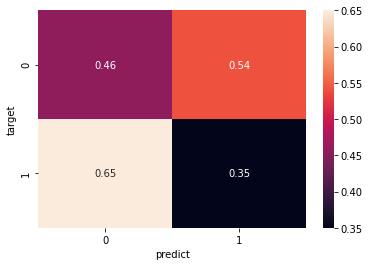

In [31]:
feature_cols = [col for col in train_dataset.columns if re.match(r'^f\d+$', col)]
st = turbohack.Statistics(train_dataset, feature_cols[0])
train_dataset = st.rolling_mse(wsize=100, threashold=0.99, prefix='mse')
turbohack.plot_confusion_matrix(train_dataset, 'target', 'mse_f1', normalize='true')

In [19]:
roll_val_m = train_markup.loc[:, 'f43'].pow(2).rolling(10).mean().apply(np.sqrt, raw=True)
roll_val_nm = train_nomarkup.loc[:, 'f43'].pow(2).rolling(10).mean().apply(np.sqrt, raw=True)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=train_nomarkup.loc[:, 'date_col'],
        y=train_nomarkup.loc[:, 'f43'] - roll_val_nm,
        name='nomarkup'
    )
)
fig.add_trace(
    go.Scatter(
        x=train_markup.loc[:, 'date_col'],
        y=train_markup.loc[:, 'f43'] - roll_val_m,
        name='markup'
    )
)
